In [1]:
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

In [2]:
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [1, 2, 3, 4, 5, 6]
PALETTE = ['#F08080', '#98FF00', '#228B22', '#FFC82D', '#A15622', '#000000']
SAMPLE_PATH = '../Conv1D_LULC_Classification/lc_gabung.csv'
#IMAGE_PATH = '../Conv1D_LULC_Classification/Sentinel_Pidie_Agustus_2024.tif'

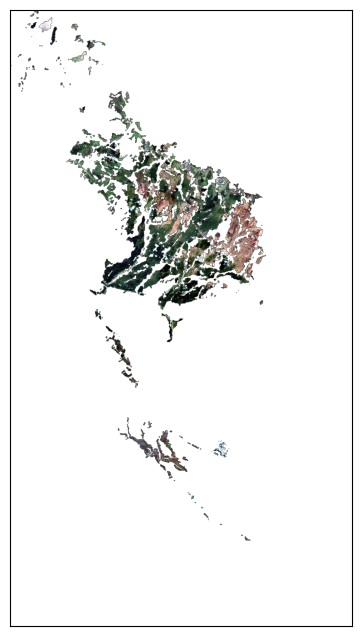

<Axes: >

In [3]:
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [1,2,3]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [4]:
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B8,B11,B12,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
5891,0.24550,0.22065,0.23965,0.21540,0.42760,0.29895,0.23525,0.498064,0.290186,0.177070,-0.281679,-0.177070,0.119244,12,5,train
23691,0.52980,0.50770,0.48040,0.45880,0.53980,0.44090,0.36840,0.417655,0.188725,0.100846,-0.058224,-0.100846,0.089584,494,5,train
9700,0.29625,0.27250,0.27710,0.25725,0.42495,0.29590,0.22350,0.453390,0.310664,0.179025,-0.210598,-0.179025,0.139392,41,5,train
9339,0.33655,0.38595,0.37535,0.36140,0.47760,0.40835,0.29165,0.386624,0.241729,0.078165,-0.119878,-0.078165,0.166714,9,5,train
14364,0.16480,0.18440,0.20640,0.19200,0.28820,0.29180,0.21730,0.227488,0.140257,-0.006207,-0.165386,0.006207,0.146337,37,2,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0.22570,0.23105,0.24575,0.24360,0.29615,0.20210,0.17095,0.128186,0.268037,0.188761,-0.093006,-0.188761,0.083501,4,1,train
3704,0.13735,0.15100,0.18165,0.15980,0.45370,0.28095,0.19290,0.574023,0.403341,0.235146,-0.428189,-0.235146,0.185818,504,4,train
25198,0.15970,0.14520,0.18490,0.16460,0.46860,0.38500,0.26140,0.555881,0.283836,0.097938,-0.434124,-0.097938,0.191213,12,5,test
13207,0.21650,0.23370,0.26960,0.27710,0.45640,0.38910,0.31310,0.328088,0.186225,0.079598,-0.257300,-0.079598,0.108231,254,1,train


In [5]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (20962, 14, 1)
Test features: (5199, 14, 1)
Train label: (20962, 7)
Test label: (5199, 7)


In [6]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.1
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel , activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool,pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool,pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 64)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 128)            16512     
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 128)            32896     
                                                        

In [7]:
# Train the model

# Compline the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=50
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
21/21 [==============================] - 2s 43ms/step - loss: 1.8706 - accuracy: 0.5048 - val_loss: 1.3074 - val_accuracy: 0.6242
Epoch 2/100
21/21 [==============================] - 1s 37ms/step - loss: 1.2661 - accuracy: 0.6000 - val_loss: 1.1694 - val_accuracy: 0.6190
Epoch 3/100
21/21 [==============================] - 1s 41ms/step - loss: 1.2056 - accuracy: 0.6007 - val_loss: 1.1295 - val_accuracy: 0.6244
Epoch 4/100
21/21 [==============================] - 1s 39ms/step - loss: 1.1689 - accuracy: 0.6010 - val_loss: 1.0765 - val_accuracy: 0.6394
Epoch 5/100
21/21 [==============================] - 1s 38ms/step - loss: 1.1035 - accuracy: 0.6074 - val_loss: 0.9898 - val_accuracy: 0.6324
Epoch 6/100
21/21 [==============================] - 1s 38ms/step - loss: 1.0087 - accuracy: 0.6470 - val_loss: 0.8990 - val_accuracy: 0.7011
Epoch 7/100
21/21 [==============================] - 1s 38ms/step - loss: 0.9363 - accuracy: 0.6900 - val_loss: 0.8473 - val_accuracy: 0.7359
Epoch 

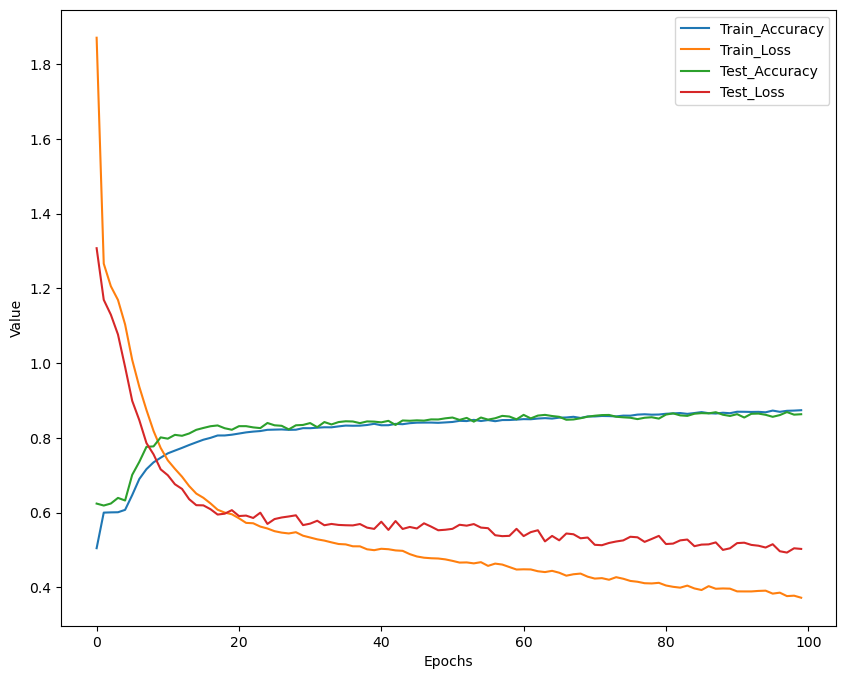

In [8]:
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

656/656 [==============================] - 1s 891us/step
              precision    recall  f1-score   support

           1       0.85      0.69      0.76      2229
           2       0.83      0.87      0.85      2571
           3       0.81      0.84      0.83      1750
           4       0.86      0.85      0.86      1123
           5       0.93      0.97      0.95     12593
           6       0.75      0.31      0.44       696

    accuracy                           0.89     20962
   macro avg       0.84      0.76      0.78     20962
weighted avg       0.89      0.89      0.88     20962



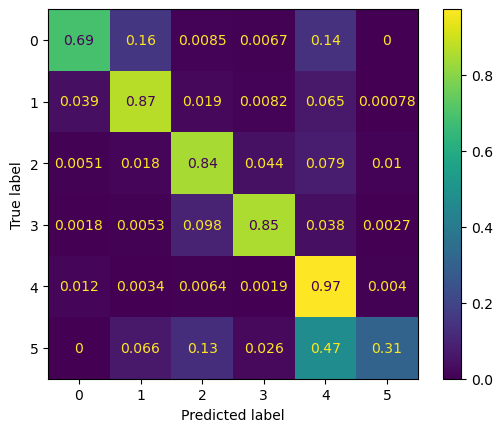

In [9]:
prediction = np.argmax(model.predict(train_input), 1).flatten()
label = np.argmax(train_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

163/163 [==============================] - 0s 810us/step
              precision    recall  f1-score   support

           1       0.90      0.73      0.80       560
           2       0.86      0.86      0.86       524
           3       0.76      0.69      0.73       413
           4       0.63      0.80      0.71       269
           5       0.90      0.96      0.93      3249
           6       0.40      0.10      0.16       184

    accuracy                           0.86      5199
   macro avg       0.74      0.69      0.70      5199
weighted avg       0.85      0.86      0.85      5199



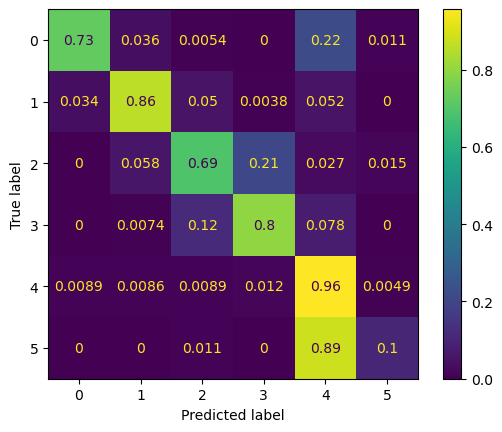

In [10]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
import numpy as np

In [12]:
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()
cm1 = confusion_matrix(label, prediction, normalize='true')
num_classes = 5
sensitivity = []
specificities = []

# Hitung sensitivitas untuk setiap kelas
for i in range(num_classes):
    TP = cm1[i, i]
    FN = np.sum(cm1[i, :]) - TP  # Jumlah semua FN untuk kelas i
    sensitivity_1 = TP / (TP + FN)
    sensitivity.append(sensitivity_1)

total = 0
for num in sensitivity:
    total += num

print("Sensitivity : ", total/6)

for i in range(num_classes):
    TN = np.sum(cm1) - np.sum(cm1[i, :]) - np.sum(cm1[:, i]) + cm1[i, i]
    FP = np.sum(cm1[:, i]) - cm1[i, i]
    specificity_1 = TN / (TN + FP)
    specificities.append(specificity_1)

total = 0
for num in specificities:
    total += num

print("Specificity : ", total/6)

mcc= matthews_corrcoef(label, prediction)
print('Matthews corrcoef : ',mcc)
KIA=cohen_kappa_score(label, prediction)
print('Cohen Kappa Index : ',KIA)

163/163 [==============================] - 0s 817us/step
Sensitivity :  0.6730923859009396
Specificity :  0.7723993969301223
Matthews corrcoef :  0.7565233348626698
Cohen Kappa Index :  0.7538749578526673


In [13]:
prediction = np.argmax(model.predict(train_input), 1).flatten()
label = np.argmax(train_output, 1).flatten()
cm1 = confusion_matrix(label, prediction, normalize='true')
num_classes = 6
sensitivity = []
specificities = []

# Hitung sensitivitas untuk setiap kelas
for i in range(num_classes):
    TP = cm1[i, i]
    FN = np.sum(cm1[i, :]) - TP  # Jumlah semua FN untuk kelas i
    sensitivity_1 = TP / (TP + FN)
    sensitivity.append(sensitivity_1)

total = 0
for num in sensitivity:
    total += num

print("Sensitivity : ", total/6)

for i in range(num_classes):
    TN = np.sum(cm1) - np.sum(cm1[i, :]) - np.sum(cm1[:, i]) + cm1[i, i]
    FP = np.sum(cm1[:, i]) - cm1[i, i]
    specificity_1 = TN / (TN + FP)
    specificities.append(specificity_1)

total = 0
for num in specificities:
    total += num

print("Specificity : ", total/6)

mcc= matthews_corrcoef(label, prediction)
print('Matthews corrcoef : ',mcc)
KIA=cohen_kappa_score(label, prediction)
print('Cohen Kappa Index : ',KIA)

656/656 [==============================] - 1s 867us/step
Sensitivity :  0.7561044120595577
Specificity :  0.9512208824119116
Matthews corrcoef :  0.8141360675475279
Cohen Kappa Index :  0.8125545301408386


656/656 [==============================] - 1s 884us/step


C:\Users\jabir\AppData\Local\Temp\ipykernel_10264\3372588128.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 7)


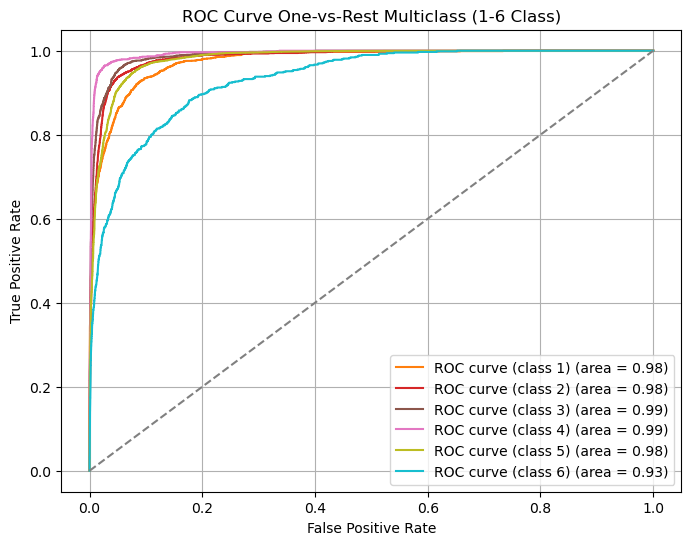

In [14]:
y_prob = model.predict(train_input)

# Hitung ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1, 7):
    fpr[i], tpr[i], _ = roc_curve(train_output[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve untuk setiap kelas
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', 7)

for i in range(1,7):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

# Plot garis diagonal untuk referensi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Tambahkan label dan judul pada plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve One-vs-Rest Multiclass (1-6 Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

163/163 [==============================] - 0s 884us/step


C:\Users\jabir\AppData\Local\Temp\ipykernel_10264\1792854876.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 8)


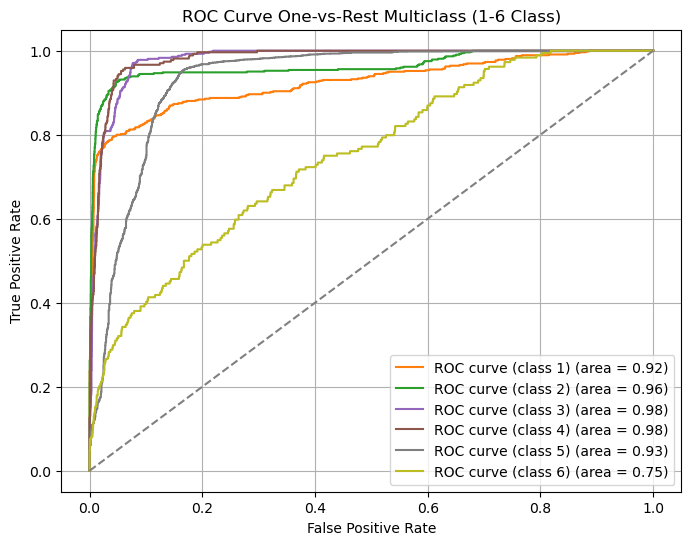

In [15]:
y_prob = model.predict(test_input)

# Hitung ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1,7):
    fpr[i], tpr[i], _ = roc_curve(test_output[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve untuk setiap kelas
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', 8)

for i in range(1,7):
    plt.plot(fpr[i], tpr[i], color=colors(i),
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

# Plot garis diagonal untuk referensi
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Tambahkan label dan judul pada plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve One-vs-Rest Multiclass (1-6 Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()